Adversarial examples are very common in generalized linear models. They could attack models via slightly perturbing the original inputs such that the small perturbation on each feature can accumulate to a significant distortion . Neural nets indeed behave very linearly, thus we can find adversarial examples by Fast Gradient Method [(Goodfellow et al., 2015)](https://arxiv.org/abs/1412.6572). Fast Gradient Method assumes that the cost function is very linear, i.e., the coefficient of the one-order term of Taylor expansion is much greater than others.
$$
adv = \epsilon{sign(g)}  
$$
$$
g = \nabla_x Loss
$$

[Koh and Liang (2017)](https://arxiv.org/abs/1703.04730) introduced an interesting method to generate adversarial examples using influence functions (a classic technique from robust statistics), this method can be used to generate targeted examples. This paper also won ICML 2017 best paper. 

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.contrib.layers import xavier_initializer

Read MNIST dataset

Extracting ../VAE/Datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../VAE/Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../VAE/Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../VAE/Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Number of training samples: 55000
Number of validation samples: 5000
Number of test samples: 10000


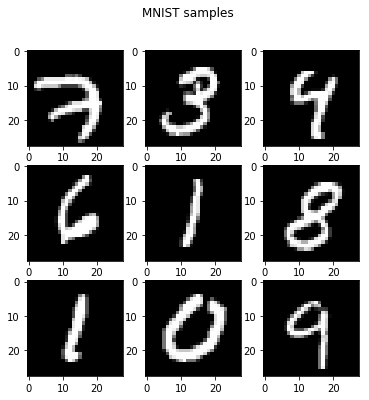

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../VAE/Datasets/MNIST_data', one_hot=False)
num_train_samples = mnist.train.num_examples
num_valid_samples = mnist.validation.num_examples
num_test_samples = mnist.test.num_examples

print("Number of training samples: %d" % num_train_samples)
print("Number of validation samples: %d" % num_valid_samples)
print("Number of test samples: %d" % num_test_samples)

# Each image has 28 * 28 = 784 pixels
samples = mnist.train.images[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("MNIST samples")
for i, image in enumerate(samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()

#### 1. we add a hidden layer with ReLU activation to the softmax classifier

In [3]:
num_features = 784
num_hidden_units = 500
num_classes = 10

W_0 = tf.get_variable("W_0", shape=[num_features, num_hidden_units], initializer=xavier_initializer())
b_0 = tf.get_variable("b_0", shape=[num_hidden_units], initializer=tf.zeros_initializer())
W_1 = tf.get_variable("W_1", shape=[num_hidden_units, num_classes], initializer=xavier_initializer())
b_1 = tf.get_variable("b_1", shape=[num_classes], initializer=tf.zeros_initializer())

def forward(X):
    layer = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    logits = tf.matmul(layer, W_1) + b_1
    return logits

#### 2. Build TensorFlow graph, we use maximum likelihood criteria, the cross entropy

In [4]:
with tf.name_scope("input"):  
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y = tf.placeholder(tf.float32, [None, 10], name='y-input')

with tf.name_scope("layers"):
    logits = forward(x)
    probabilities = tf.nn.softmax(logits)
    probabilities = tf.cast(probabilities, tf.float64)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    train_op = tf.train.AdagradOptimizer(0.1).minimize(loss)

with tf.name_scope("Accuracy"):  
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name="correct_prediction")
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

#### 3. Training and saving models

In [5]:
TRAINING_STEPS = 2000
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    validate_feed = {x: mnist.validation.images, y: mnist.validation.labels}
    test_feed = {x: mnist.test.images, y: mnist.test.labels} 
    saver = tf.train.Saver()
    ave = 0
    for i in range(TRAINING_STEPS):
        if i % 100 == 0 and i != 0:
            validate_acc, validate_loss = sess.run([accuracy, loss], feed_dict=validate_feed)
            print("After %d training step(s), validation accuracy %g, valid loss %g" % (i, validate_acc, validate_loss))
            
        xs,ys=mnist.train.next_batch(64)
        _, loss_val = sess.run([train_op, loss],feed_dict={x:xs, y:ys})
        ave += loss_val
        if i % 100 == 0 and i != 0:
            saver.save(sess, "save/" + 'mnist.ckpt', global_step=i)
            ave = ave / 1000
            print("Train loss %g" % ave)
            print("--------------------------------\n")
            ave = 0
    
    test_acc, test_loss=sess.run([accuracy, loss],feed_dict=test_feed)
    saver.save(sess, "save/" + 'mnist.ckpt', global_step=i)
    print(("After %d training step(s), test accuracy %g, test loss %g" %(TRAINING_STEPS, test_acc, test_loss)))
    
#writer = tf.summary.FileWriter("ad.log", tf.get_default_graph())
#writer.close()

After 100 training step(s), validation accuracy 0.8854, valid loss 0.386996
Train loss 0.0589521
--------------------------------

After 200 training step(s), validation accuracy 0.9238, valid loss 0.263393
Train loss 0.0333743
--------------------------------

After 300 training step(s), validation accuracy 0.939, valid loss 0.21324
Train loss 0.0266591
--------------------------------

After 400 training step(s), validation accuracy 0.941, valid loss 0.20125
Train loss 0.0218618
--------------------------------

After 500 training step(s), validation accuracy 0.9566, valid loss 0.165454
Train loss 0.0190424
--------------------------------

After 600 training step(s), validation accuracy 0.9564, valid loss 0.152657
Train loss 0.0180744
--------------------------------

After 700 training step(s), validation accuracy 0.9632, valid loss 0.145376
Train loss 0.0169662
--------------------------------

After 800 training step(s), validation accuracy 0.9626, valid loss 0.138877
Train loss 

#### Read models and analysis

In [5]:
sess = tf.Session()
ckpt = tf.train.get_checkpoint_state("save")
sess.run(tf.global_variables_initializer())
restorer = tf.train.Saver()
restorer.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from save/mnist.ckpt-1999


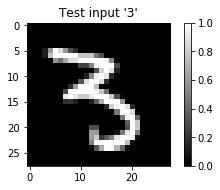

Ground truth:  3 |Prediction: 3 |Result:  True
Softmax probabilities: [0.0, 0.0, 0.0, 0.999, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0]




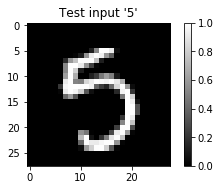

Ground truth:  5 |Prediction: 5 |Result:  True
Softmax probabilities: [0.001, 0.0, 0.0, 0.0, 0.0, 0.997, 0.0, 0.001, 0.0, 0.002]




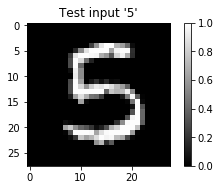

Ground truth:  5 |Prediction: 5 |Result:  True
Softmax probabilities: [0.0, 0.0, 0.0, 0.002, 0.0, 0.998, 0.0, 0.0, 0.0, 0.0]




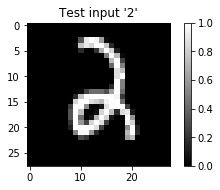

Ground truth:  2 |Prediction: 2 |Result:  True
Softmax probabilities: [0.0, 0.0, 0.999, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0]




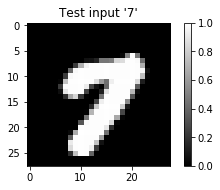

Ground truth:  7 |Prediction: 7 |Result:  True
Softmax probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.996, 0.001, 0.002]




In [49]:
x_sample, labels = mnist.test.next_batch(5)
ground_truth = [np.argmax(i) for i in labels]

probabilities_val = sess.run(probabilities, feed_dict={x: x_sample})
predictions = [np.argmax(i) for i in probabilities_val]
probabilities_val = [np.round(i, decimals=3) for i in probabilities_val]

for i in range(5):
    plt.figure(figsize=(8, 12))
    plt.subplot(5, 2, 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input '%d'" % ground_truth[i])
    result = ground_truth[i] == predictions[i] 
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    print("Ground truth: ", ground_truth[i], "|Prediction:", predictions[i], "|Result: ", result)
    print("Softmax probabilities:", [float(i) for i in probabilities_val[i]])
    print("\n")

In [6]:
def fast_grad_method(x, loss, epsilon):
    grads = tf.gradients(loss, [x])[0]
    #No back propogation
    grads = tf.stop_gradient(grads)
    return x + epsilon * tf.sign(grads)

In [68]:
with tf.name_scope("Adversarial_examples"):
    x_adv = fast_grad_method(x, loss, 0.06)

adv_examples = sess.run(x_adv, feed_dict={x: x_sample, y: labels})

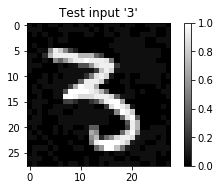

Ground truth:  3 |Prediction: 5 |Result:  False
Softmax probabilities: [0.0, 0.0, 0.002, 0.321, 0.007, 0.623, 0.0, 0.0, 0.041, 0.005]




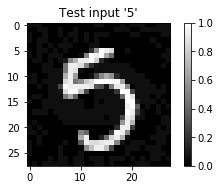

Ground truth:  5 |Prediction: 9 |Result:  False
Softmax probabilities: [0.05, 0.0, 0.0, 0.004, 0.016, 0.385, 0.009, 0.083, 0.009, 0.443]




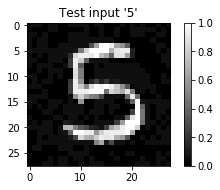

Ground truth:  5 |Prediction: 3 |Result:  False
Softmax probabilities: [0.0, 0.0, 0.0, 0.779, 0.0, 0.218, 0.0, 0.0, 0.003, 0.0]




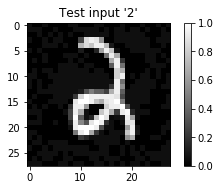

Ground truth:  2 |Prediction: 2 |Result:  True
Softmax probabilities: [0.0, 0.0, 0.529, 0.0, 0.004, 0.0, 0.466, 0.0, 0.0, 0.0]




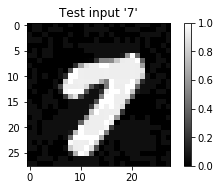

Ground truth:  7 |Prediction: 9 |Result:  False
Softmax probabilities: [0.0, 0.0, 0.0, 0.007, 0.004, 0.001, 0.0, 0.23, 0.296, 0.46]




In [69]:
probabilities_val = sess.run(probabilities, feed_dict={x: adv_examples})
predictions = [np.argmax(i) for i in probabilities_val]
probabilities_val = [np.round(i, decimals=3) for i in probabilities_val]

for i in range(5):
    plt.figure(figsize=(8, 12))
    plt.subplot(5, 2, 1)
    plt.imshow(adv_examples[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input '%d'" % ground_truth[i])
    result = ground_truth[i] == predictions[i] 
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    print("Ground truth: ", ground_truth[i], "|Prediction:", predictions[i], "|Result: ", result)
    print("Softmax probabilities:", [float(i) for i in probabilities_val[i]])
    print("\n")